<a href="https://colab.research.google.com/github/laurazanetti98/Forecasting_GDP/blob/main/Project_GDP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GDP Forecasting project
The dataset under consideration contains estimates of total GDP (gross domestic product) and its components for several countries over the period 1970-2020. Information are available for 220 countries and 17 different indicators were derived.
The main aim of this project is to forecast the total GDP for the last 10 years (2010-2020), for five different states: Italy, United States, India, Singapore,China and United Kingdom. In order to do that we are gonna use different models (Linear Regression, ETS models and ARIMA) and compare them in terms of AIC and RMSE. We are also gonna visualize and analyze some other (italian) variables other than the GDP as: Exports, Imports, Manufacturing (ISIC D) and Gross capital formation.

**Glossary** 
*  **Gross Domestic Product (GDP)** --> the total of all value added created in an economy.
*  **Gross capital formation** --> consists of outlays on additions to the fixed assets of the economy plus net changes in the level of inventories
*  **Imports of goods and services** --> represent the value of all goods and other market services received from the rest of the world.
*  **Exports of goods and services** --> represent the value of all goods and other market services provided to the rest of the world. 
*  **Manufacturing (ISIC D)**	--> is the net output of a sector after adding up all outputs and subtracting intermediate inputs.



#1.Project exploration and cleaning

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn; seaborn.set()
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy import stats, signal
from numpy.fft import fft, ifft
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.exponential_smoothing.ets import ETSModel 
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import durbin_watson

In [2]:
excel = 'GDPcountries.xlsx'
data = pd.read_excel(excel, header=2)
data.drop(['CountryID'], axis=1, inplace=True)
data.head(3)


,Country,IndicatorName,1970,1971,1972,1973,1974,1975,1976,1977,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,Afghanistan,Final consumption expenditure,3.068715e+09,2.957075e+09,2.886788e+09,3.100416e+09,3.328662e+09,3.514642e+09,3.587322e+09,3.825474e+09,...,1.153494e+10,1.537617e+10,1.849492e+10,1.856572e+10,1.912682e+10,1.930930e+10,1.813094e+10,2.154508e+10,2.494428e+10,2.210259e+10
1,Afghanistan,Household consumption expenditure (including N...,2.734161e+09,2.614420e+09,2.529175e+09,2.724908e+09,2.941860e+09,3.012107e+09,3.032225e+09,3.230522e+09,...,8.263218e+09,1.170813e+10,1.463690e+10,1.460849e+10,1.497766e+10,1.494902e+10,1.404900e+10,1.767663e+10,1.998886e+10,1.835413e+10
2,Afghanistan,General government final consumption expenditure,3.288787e+08,3.375334e+08,3.530078e+08,3.704164e+08,3.810549e+08,4.980797e+08,5.512724e+08,5.909253e+08,...,3.284910e+09,3.673733e+09,3.855382e+09,3.956030e+09,4.149161e+09,4.363228e+09,4.084496e+09,3.854648e+09,4.947607e+09,3.730520e+09


Below I melted different columns into one in order to have one column for the Date variable.

In [3]:
#melting different columns in one (Date)
dt = data.melt(id_vars =['Country', 'IndicatorName'],
            var_name = 'Date',
            value_name = 'Value').dropna()
dt.head()

,Country,IndicatorName,Date,Value
0,Afghanistan,Final consumption expenditure,1970,3.068715e+09
1,Afghanistan,Household consumption expenditure (including N...,1970,2.734161e+09
2,Afghanistan,General government final consumption expenditure,1970,3.288787e+08
3,Afghanistan,Gross capital formation,1970,1.654637e+09
4,Afghanistan,Gross fixed capital formation (including Acqui...,1970,1.653901e+09


Setting the Date as index

In [4]:
#setting Date as index
dt['Date']= pd.to_datetime(dt['Date'], format= "%Y")
dt = dt.set_index(dt['Date'])
dt.drop(['Date'], axis=1, inplace=True)
dt.head(5)

,Country,IndicatorName,Value
Date,,,
1970-01-01,Afghanistan,Final consumption expenditure,3.068715e+09
1970-01-01,Afghanistan,Household consumption expenditure (including N...,2.734161e+09
1970-01-01,Afghanistan,General government final consumption expenditure,3.288787e+08
1970-01-01,Afghanistan,Gross capital formation,1.654637e+09
1970-01-01,Afghanistan,Gross fixed capital formation (including Acqui...,1.653901e+09


In [5]:
#Considering a subset of variables besides GDP (such as exports, imports, manufactoring, gross capital)
options = ['Gross Domestic Product (GDP)', 'Exports of goods and services', 'Imports of goods and services','Manufacturing (ISIC D)','Gross capital formation'] 
dataset= dt[dt.IndicatorName.isin(options)]
dataset.head()


,Country,IndicatorName,Value
Date,,,
1970-01-01,Afghanistan,Gross capital formation,1.654637e+09
1970-01-01,Afghanistan,Exports of goods and services,1.546737e+08
1970-01-01,Afghanistan,Imports of goods and services,1.622465e+08
1970-01-01,Afghanistan,Gross Domestic Product (GDP),1.046759e+10
1970-01-01,Afghanistan,Manufacturing (ISIC D),1.027537e+09


In [6]:
#Focusing on 5 different countries: United States, Italy, India, Singapore, China, United Kingdom 
options = ['United States', 'Italy', 'India','Singapore','China','United Kingdom'] 
dataset= dataset[dataset.Country.isin(options)]
dataset

,Country,IndicatorName,Value
Date,,,
1970-01-01,China,Gross capital formation,7.682141e+10
1970-01-01,China,Exports of goods and services,5.240282e+09
1970-01-01,China,Imports of goods and services,5.603186e+09
1970-01-01,China,Gross Domestic Product (GDP),2.312103e+11
1970-01-01,India,Gross capital formation,3.149193e+10
...,...,...,...
2020-01-01,United States,Gross capital formation,4.157006e+12
2020-01-01,United States,Exports of goods and services,2.105427e+12
2020-01-01,United States,Imports of goods and services,2.839772e+12


In [7]:
#Pivot Italian variables
#subset of italian variables
df = dataset[dataset['Country'] == 'Italy']
pivot = pd.pivot_table(data=df, index='Date',columns='IndicatorName', values='Value')
display(pivot.head(5))
pivot.info()

IndicatorName,Exports of goods and services,Gross Domestic Product (GDP),Gross capital formation,Imports of goods and services,Manufacturing (ISIC D)
Date,,,,,
1970-01-01,8.713649e+10,8.466100e+11,1.995984e+11,9.790250e+10,1.117828e+11
1971-01-01,9.362138e+10,8.620023e+11,1.857224e+11,1.008217e+11,1.128224e+11
1972-01-01,1.015493e+11,8.938143e+11,1.936139e+11,1.108496e+11,1.205297e+11
1973-01-01,1.076318e+11,9.575063e+11,2.248657e+11,1.215436e+11,1.370278e+11
1974-01-01,1.153222e+11,1.010171e+12,2.461164e+11,1.252762e+11,1.483357e+11


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 51 entries, 1970-01-01 to 2020-01-01
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Exports of goods and services  51 non-null     float64
 1   Gross Domestic Product (GDP)   51 non-null     float64
 2   Gross capital formation        51 non-null     float64
 3   Imports of goods and services  51 non-null     float64
 4   Manufacturing (ISIC D)         51 non-null     float64
dtypes: float64(5)
memory usage: 2.4 KB


No Null value

In [8]:
#italian GDP
ita_gdp = df[df['IndicatorName'] == 'Gross Domestic Product (GDP)'	]
ita_gdp = ita_gdp.drop(['Country',	'IndicatorName'], axis=1)
ita_gdp.head(5)

,Value
Date,
1970-01-01,8.466100e+11
1971-01-01,8.620023e+11
1972-01-01,8.938143e+11
1973-01-01,9.575063e+11
1974-01-01,1.010171e+12


#2.Data Visualization

* We are first gonna visualize and plot the GDP for our five different countries. We'll take in consideration the GDP per capita of 2020 and compare it to GDP 2020 and see how the countries' ranking change.
* Then we'll analyse and visualize the italian variables.

## Plotting GDP of 5 different countries

In [9]:
#We are considering now just the GDP of the 5 chosen countries
gdp = dataset[dataset['IndicatorName'].str.contains('gdp'.upper())]
gdp.tail()

,Country,IndicatorName,Value
Date,,,
2020-01-01,India,Gross Domestic Product (GDP),2.551441e+12
2020-01-01,Italy,Gross Domestic Product (GDP),1.744732e+12
2020-01-01,Singapore,Gross Domestic Product (GDP),3.300938e+11
2020-01-01,United Kingdom,Gross Domestic Product (GDP),2.882116e+12
2020-01-01,United States,Gross Domestic Product (GDP),1.924706e+13


In [10]:
#Creation of a pivot with all 5 countries under consideation
pivot1 = pd.pivot_table(data=gdp, index='Date',columns='Country', values='Value')
display(pivot1.tail(5))

Country,China,India,Italy,Singapore,United Kingdom,United States
Date,,,,,,
2016-01-01,1.181915e+13,2.324002e+12,1.859646e+12,3.182519e+11,3.023495e+12,1.850960e+13
2017-01-01,1.264025e+13,2.481926e+12,1.890662e+12,3.326381e+11,3.088030e+12,1.892712e+13
2018-01-01,1.349344e+13,2.644070e+12,1.908166e+12,3.442720e+11,3.139011e+12,1.947958e+13
2019-01-01,1.429637e+13,2.750932e+12,1.915995e+12,3.489032e+11,3.191493e+12,1.992544e+13
2020-01-01,1.463198e+13,2.551441e+12,1.744732e+12,3.300938e+11,2.882116e+12,1.924706e+13


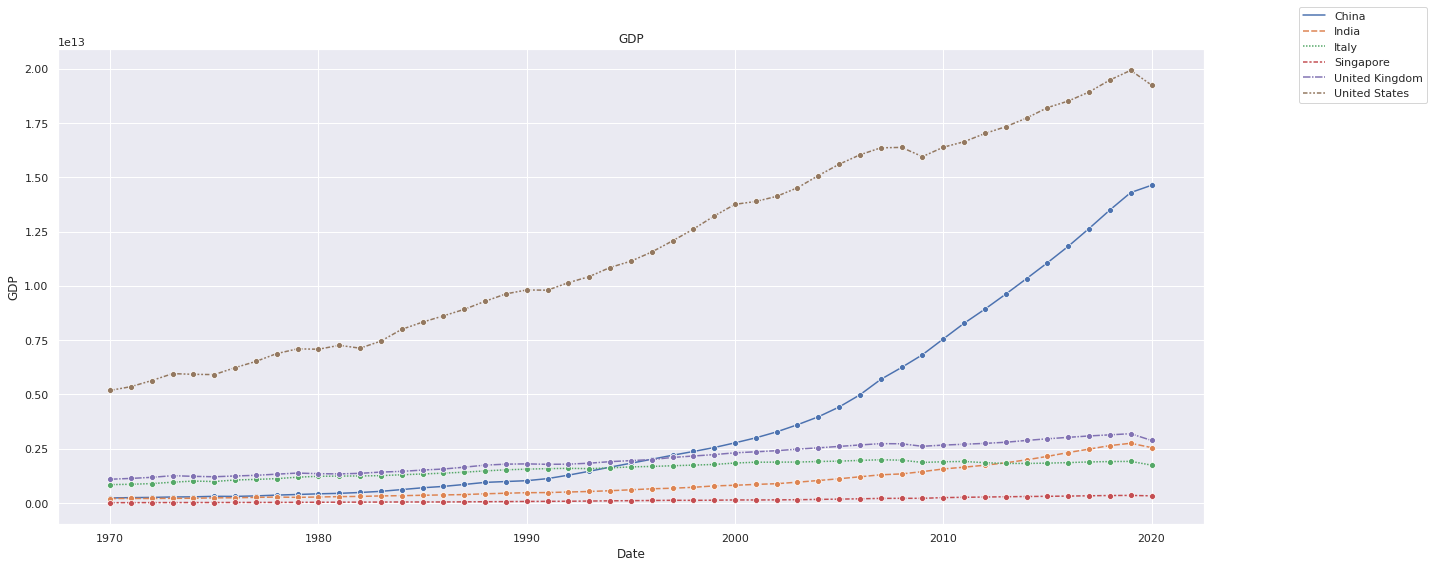

In [11]:
#Comparing GDP of the 5 different countries during the years
import seaborn as sns; sns.set()
fig= plt.figure(figsize=(20,8))
sns.lineplot(data=pivot1, marker="o")
sns.set_style('whitegrid')
plt.title('GDP')
plt.xlabel('Date')
plt.ylabel('GDP')
plt.legend(bbox_to_anchor=(1.2,1.1))
plt.tight_layout()
plt.show()

Following we will consider just year 2020

In [12]:
#Considering just year 2020
df = gdp.query("Date==2020")

In [13]:
#importing alpha codes that are gonna be used for the choropleth map
url="https://raw.githubusercontent.com/lukes/ISO-3166-Countries-with-Regional-Codes/master/all/all.csv"
c=pd.read_csv(url)
c = c[['name',	'alpha-2',	'alpha-3']]
c.rename(columns={'name':'Country'}, inplace=True)
c = c.replace('United Kingdom of Great Britain and Northern Ireland', 'United Kingdom')
c = c.replace('United States of America', 'United States')

In [14]:
#merging two datasets
new_gdp = df.merge(c, on='Country')
new_gdp.tail()

,Country,IndicatorName,Value,alpha-2,alpha-3
1,India,Gross Domestic Product (GDP),2.551441e+12,IN,IND
2,Italy,Gross Domestic Product (GDP),1.744732e+12,IT,ITA
3,Singapore,Gross Domestic Product (GDP),3.300938e+11,SG,SGP
4,United Kingdom,Gross Domestic Product (GDP),2.882116e+12,GB,GBR
5,United States,Gross Domestic Product (GDP),1.924706e+13,US,USA


In [15]:
#Importing and merging Country Population with our dataset of interest in order to compute GDP per capita
url1 = "https://gist.githubusercontent.com/Aglaina/387f1f7b8c507fc50bf529b6ce1d22ef/raw/05ba873d606783fd8397cb51e223438f087f63ee/population.csv"
pop = pd.read_csv(url1)
pop = pop.query("Year==2020")
pop = pop[['Country', 'Population']]
pop.head()
new_gdp = new_gdp.merge(pop,how='inner', on='Country')
new_gdp['GDP per capita'] = new_gdp.Value/new_gdp.Population
new_gdp.head()

,Country,IndicatorName,Value,alpha-2,alpha-3,Population,GDP per capita
0,China,Gross Domestic Product (GDP),1.463198e+13,CN,CHN,1439323776,10165.872658
1,India,Gross Domestic Product (GDP),2.551441e+12,IN,IND,1380004385,1848.864125
2,Italy,Gross Domestic Product (GDP),1.744732e+12,IT,ITA,60461826,28856.752553
3,Singapore,Gross Domestic Product (GDP),3.300938e+11,SG,SGP,5850342,56422.990956
4,United Kingdom,Gross Domestic Product (GDP),2.882116e+12,GB,GBR,67886011,42455.225232


In [16]:
#Choropleth map GDP in 2020 (of our 5 countries of interest)
import plotly.express as px
fig1 = px.choropleth(new_gdp, locations="alpha-3",
                    color="Value",
                    title = "GDP 2020", 
                    color_continuous_scale=px.colors.sequential.Plasma)
fig1.show()
#Choropleth map GDP per capita in 2020 (of our 5 countries of interest)
fig2 = px.choropleth(new_gdp, locations="alpha-3",
                    color="GDP per capita",
                    title = "GDP per capita 2020", 
                    color_continuous_scale=px.colors.sequential.Plasma)
fig2.show()

We can notice that, when we pass from a choropleth mapping the **GDP** to one that maps the **GDP per capita**, things change; for example China, the second country for GDP value, is much lower in the rank when we consider GDP per capita. In general GDP per capita, is by design an indicator of the total income generated by economic activity in a country and is often used as a measure of people’s material well-being.

Text(0, 0.5, 'GDP per capita')

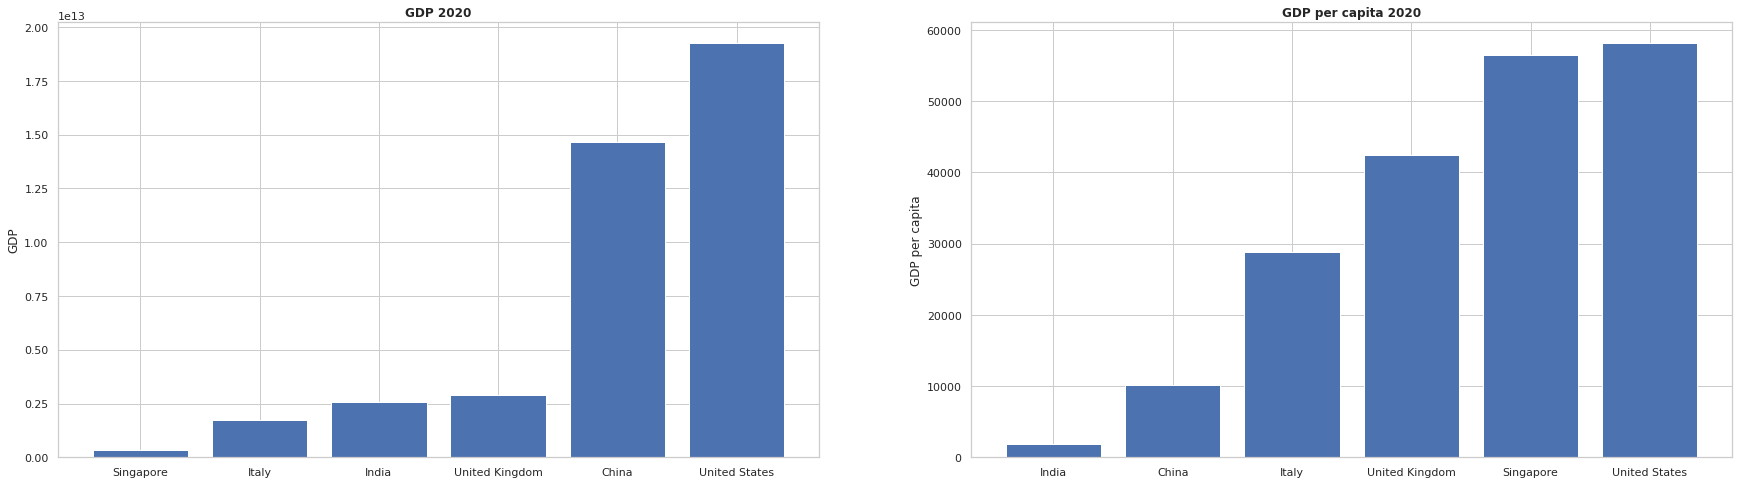

In [17]:
#Barplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30,8))

df = df.sort_values('Value')
ax1.bar(df.Country, df.Value)
ax1.set_title('GDP 2020', fontweight="bold")
ax1.set_ylabel('GDP')

new_gdp = new_gdp.sort_values('GDP per capita')
ax2.bar(new_gdp.Country, new_gdp['GDP per capita'])
ax2.set_title('GDP per capita 2020', fontweight="bold")
ax2.set_ylabel('GDP per capita')

## Plotting italian variables

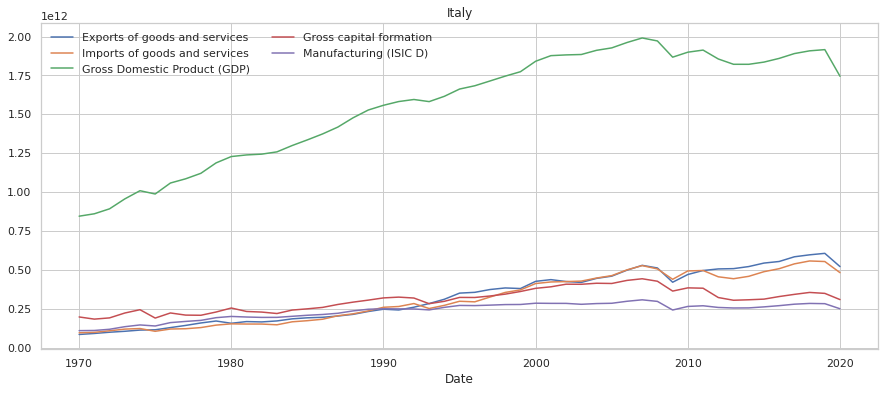

In [18]:
#Plotting italian variables
from matplotlib import rcParams
rcParams['figure.figsize'] = 15,6
plt.plot(pivot['Exports of goods and services'],label='Exports of goods and services')
plt.plot(pivot['Imports of goods and services'], label='Imports of goods and services')
plt.plot(pivot['Gross Domestic Product (GDP)'], label='Gross Domestic Product (GDP)')
plt.plot(pivot['Gross capital formation'], label='Gross capital formation')
plt.plot(pivot['Manufacturing (ISIC D)'], label='Manufacturing (ISIC D)')
plt.title("Italy")
plt.xlabel("Date")
plt.legend(frameon=False, loc='upper left', ncol=2);

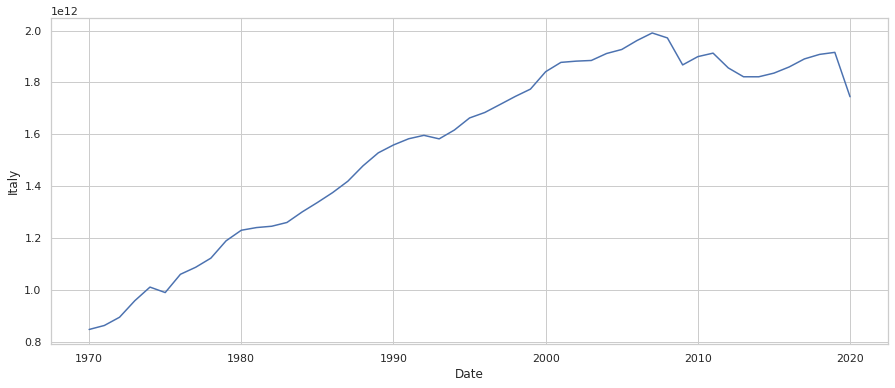

In [19]:
#GDP Italy with seaborn
sns.lineplot(data=pivot1, x= 'Date', y='Italy', ci='sd',estimator='mean');

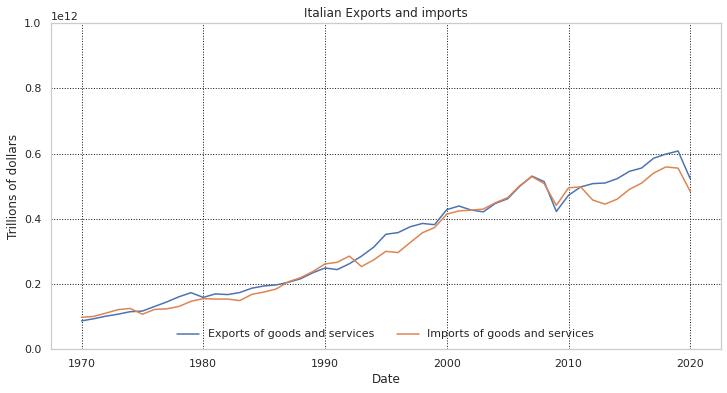

In [20]:
#plotting italian exports and imports
rcParams['figure.figsize'] = 12,6
plt.plot(pivot['Exports of goods and services'],label='Exports of goods and services')
plt.plot(pivot['Imports of goods and services'], label='Imports of goods and services')
plt.grid(True, color='k', linestyle=':')
plt.title("Italian Exports and imports")
plt.ylim([0, 1e12])
plt.xlabel("Date")
plt.ylabel("Trillions of dollars")
plt.legend(frameon=False, loc='lower center', ncol=2);

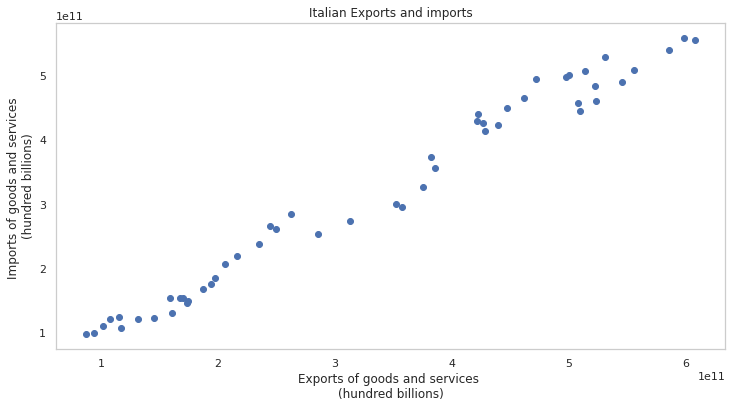

In [21]:
#scatter plot of italian exports and imports --> we can observe a strong correlation
plt.scatter(pivot['Exports of goods and services'], pivot['Imports of goods and services'])
plt.grid()
plt.title("Italian Exports and imports")
plt.xlabel('Exports of goods and services \n(hundred billions)')
plt.ylabel('Imports of goods and services \n(hundred billions)');

In [22]:
#Correlation between Exports and Imports
x = pivot['Exports of goods and services']
y = pivot['Imports of goods and services']
def correlation(x,y): 
  A = np.sum((x-np.mean(x))*(y-np.mean(y)))
  B = np.sum((x-np.mean(x))**2) *np.sum((y-np.mean(y))**2)
  corr = A/(B)**0.5
  return(corr)

A = correlation(x,y)
print('Correlation value is:',A)

Correlation value is: 0.9893133329903273


In [23]:
#Correlation between Exports and GDP
x = pivot['Exports of goods and services']
y = pivot['Gross Domestic Product (GDP)']
A = correlation(x,y)
print('Correlation value is:',A)

Correlation value is: 0.9354107585379339


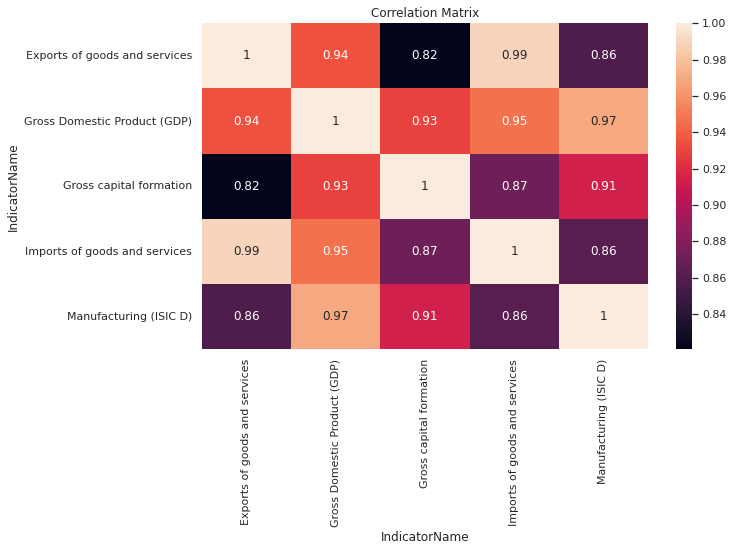

In [24]:
#Correlation Matrix --> all the variables are in same way correlated with eachother
fig, ax = plt.subplots(figsize=(10, 6))
corr_mat = pivot.corr()
sns.heatmap(corr_mat, annot=True)
plt.title('Correlation Matrix')
plt.show()

We can see from the correlation matrix that all the variables are in some way correlated with each other. (In a regression model we can incur in a Multicollinearity problem)

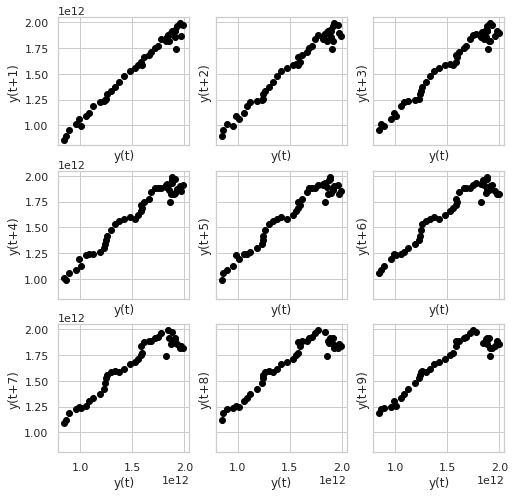

In [25]:
#Let's look now at the autocorrelation of the GDP
signal_gdp = pivot['Gross Domestic Product (GDP)']

# Lag plots for the Italian GDP
fig, axes = plt.subplots(3,3, sharex=True, sharey=True, figsize=(8,8))

for i, ax in enumerate(axes.flatten()[:9]):
    pd.plotting.lag_plot(signal_gdp, lag=i+1, ax=ax, c='black')
    ax.set_xlabel("y(t)")
    ax.set_ylabel("y(t+"+str(i+1)+")")

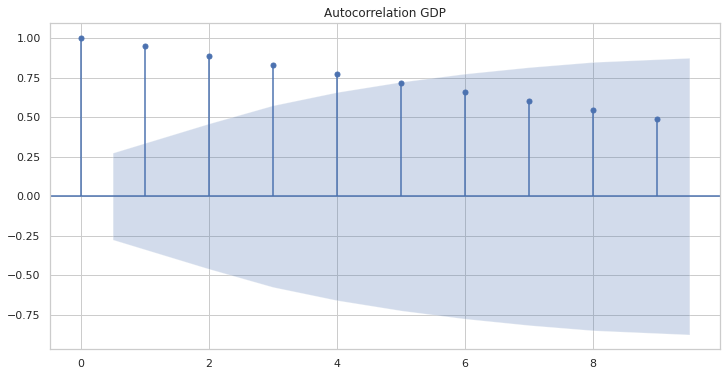

In [26]:
# Automatic plot of the ACF function
plot_acf(signal_gdp, lags=9, title = 'Autocorrelation GDP');

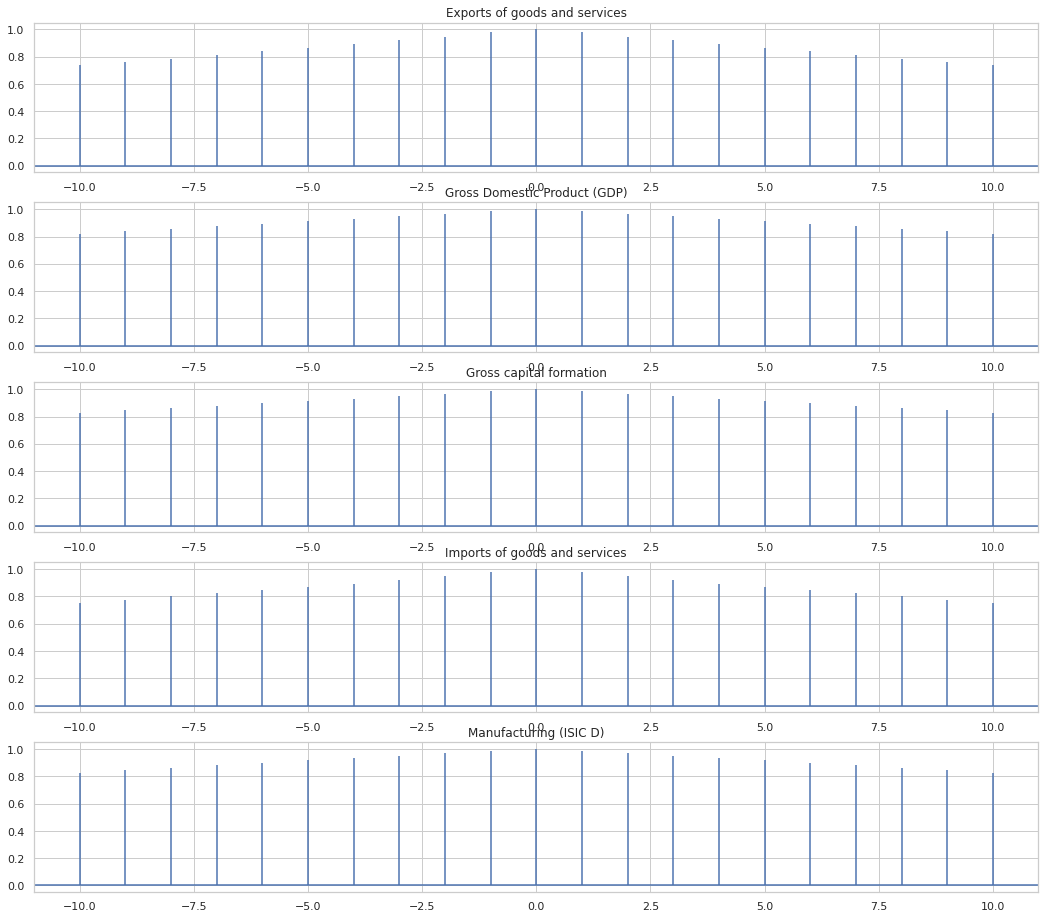

In [27]:
#ACF for all italian variables
n = 5
fig = plt.figure(figsize=(18, 16))
fig.tight_layout()
for i in range(len(pivot.columns)):
  plt.subplot(n,int(len(pivot.columns)/n), i+1)
  plt.acorr(pivot[pivot.columns[i]],normed = True, maxlags = 10)
  plt.title(str(pivot.columns[i]))
plt.show()

All the variables present high autocorrelation

##Frequency Analysis
for checking periodicity

In [28]:
signal_gdp.head()

Date
1970-01-01    8.466100e+11
1971-01-01    8.620023e+11
1972-01-01    8.938143e+11
1973-01-01    9.575063e+11
1974-01-01    1.010171e+12
Name: Gross Domestic Product (GDP), dtype: float64

,Freq,Period,Power
0,0.078431,12.750000,2.669222e+23
1,0.235294,4.250000,2.505276e+22
2,0.313725,3.187500,1.043016e+22
3,0.411765,2.428571,8.776074e+21


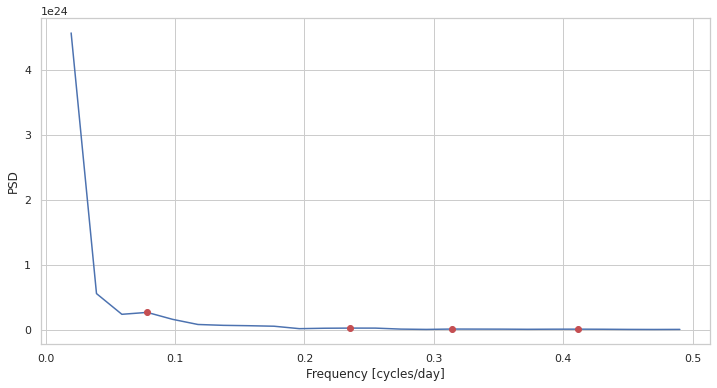

In [29]:
#PSD using the raw periodogram
Fs = 1 #our unit of measure is "years", thus 1 per year
f_per, Pxx_per = signal.periodogram(signal_gdp,Fs,detrend=None,window=None,return_onesided=True,scaling='density')
plt.plot(f_per[1:],Pxx_per[1:])
plt.ylabel('PSD')
plt.xlabel('Frequency [cycles/day]');

peaks = signal.find_peaks(Pxx_per[f_per >=0], prominence=100)[0]
peak_freq =  f_per[peaks]
peak_power = Pxx_per[peaks]
plt.plot(peak_freq, peak_power, 'ro');

data = {'Freq': peak_freq, 'Period': 1/peak_freq, 'Power': peak_power}
df = pd.DataFrame(data)
display(df)

4 peaks; (12, 4, 3, 2 years) repetition of our data

In [30]:
signal_exp = pivot['Exports of goods and services']
signal_exp.head()

Date
1970-01-01    8.713649e+10
1971-01-01    9.362138e+10
1972-01-01    1.015493e+11
1973-01-01    1.076318e+11
1974-01-01    1.153222e+11
Name: Exports of goods and services, dtype: float64

,Freq,Period,Power
0,0.156863,6.375000,1.684092e+22
1,0.235294,4.250000,6.887010e+21
2,0.313725,3.187500,4.114649e+21
3,0.411765,2.428571,2.839842e+21


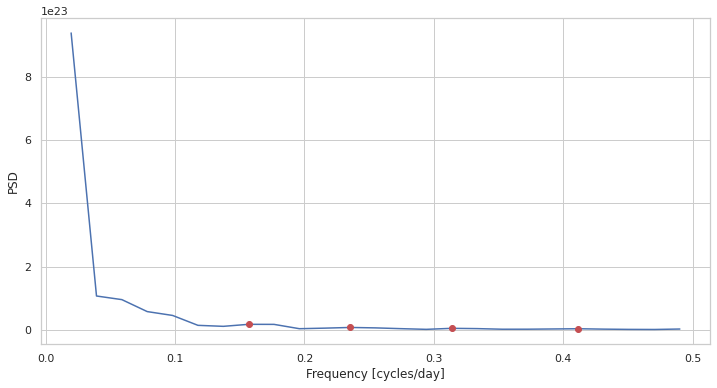

In [31]:
Fs = 1 #our unit of measure is "years", thus 1 per year
f_per, Pxx_per = signal.periodogram(signal_exp,Fs,detrend=None,window=None,return_onesided=True,scaling='density')
plt.plot(f_per[1:],Pxx_per[1:])
plt.ylabel('PSD')
plt.xlabel('Frequency [cycles/day]');

peaks = signal.find_peaks(Pxx_per[f_per >=0], prominence=100)[0]
peak_freq =  f_per[peaks]
peak_power = Pxx_per[peaks]
plt.plot(peak_freq, peak_power, 'ro');

data = {'Freq': peak_freq, 'Period': 1/peak_freq, 'Power': peak_power}
df = pd.DataFrame(data)
display(df)

#3.Decomposition of italian variables

In [32]:
display(ita_gdp.index)
ita_gdp = ita_gdp.asfreq('AS') #annual indexing, 'AS' for start of year
ita_gdp.index

DatetimeIndex(['1970-01-01', '1971-01-01', '1972-01-01', '1973-01-01',
               '1974-01-01', '1975-01-01', '1976-01-01', '1977-01-01',
               '1978-01-01', '1979-01-01', '1980-01-01', '1981-01-01',
               '1982-01-01', '1983-01-01', '1984-01-01', '1985-01-01',
               '1986-01-01', '1987-01-01', '1988-01-01', '1989-01-01',
               '1990-01-01', '1991-01-01', '1992-01-01', '1993-01-01',
               '1994-01-01', '1995-01-01', '1996-01-01', '1997-01-01',
               '1998-01-01', '1999-01-01', '2000-01-01', '2001-01-01',
               '2002-01-01', '2003-01-01', '2004-01-01', '2005-01-01',
               '2006-01-01', '2007-01-01', '2008-01-01', '2009-01-01',
               '2010-01-01', '2011-01-01', '2012-01-01', '2013-01-01',
               '2014-01-01', '2015-01-01', '2016-01-01', '2017-01-01',
               '2018-01-01', '2019-01-01', '2020-01-01'],
              dtype='datetime64[ns]', name='Date', freq=None)

DatetimeIndex(['1970-01-01', '1971-01-01', '1972-01-01', '1973-01-01',
               '1974-01-01', '1975-01-01', '1976-01-01', '1977-01-01',
               '1978-01-01', '1979-01-01', '1980-01-01', '1981-01-01',
               '1982-01-01', '1983-01-01', '1984-01-01', '1985-01-01',
               '1986-01-01', '1987-01-01', '1988-01-01', '1989-01-01',
               '1990-01-01', '1991-01-01', '1992-01-01', '1993-01-01',
               '1994-01-01', '1995-01-01', '1996-01-01', '1997-01-01',
               '1998-01-01', '1999-01-01', '2000-01-01', '2001-01-01',
               '2002-01-01', '2003-01-01', '2004-01-01', '2005-01-01',
               '2006-01-01', '2007-01-01', '2008-01-01', '2009-01-01',
               '2010-01-01', '2011-01-01', '2012-01-01', '2013-01-01',
               '2014-01-01', '2015-01-01', '2016-01-01', '2017-01-01',
               '2018-01-01', '2019-01-01', '2020-01-01'],
              dtype='datetime64[ns]', name='Date', freq='AS-JAN')

In [33]:
ita_gdp.head()

,Value
Date,
1970-01-01,8.466100e+11
1971-01-01,8.620023e+11
1972-01-01,8.938143e+11
1973-01-01,9.575063e+11
1974-01-01,1.010171e+12


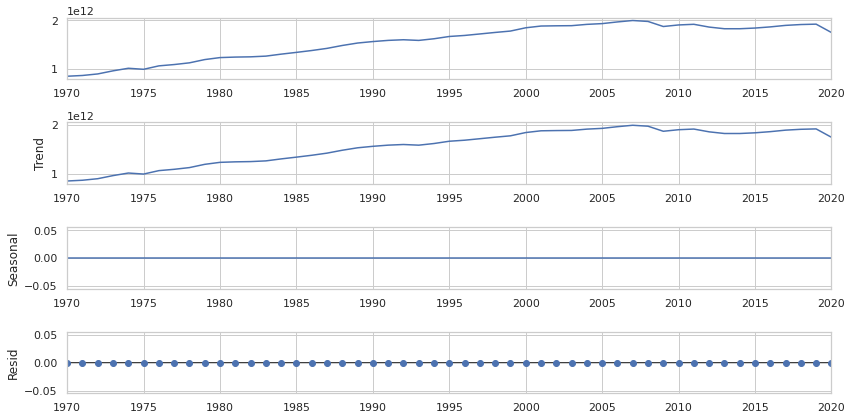

In [34]:
from statsmodels.tsa.seasonal import seasonal_decompose

#Decomposing italian GDP
decompose_data_add = seasonal_decompose(ita_gdp, model='additive') # period is automatically set
decompose_data_add.plot()
plt.show()

After performing the decomposition, we can see that the entire series was taken as the trend component and that there was no seasonality. We can also see that the residual plot shows zero. In this case it seems that the classical decomposition was not able to separate the noise that we added from the linear trend. Probably because the data is yearly and so period=1.

Now we are gonna decompose also the other italian variables (imports, exports, manufacturing, gross capital formation)

In [35]:
exports = pivot['Exports of goods and services']
exports.asfreq('AS')
imports = pivot['Imports of goods and services']
imports.asfreq('AS')
gross_cap_form = pivot['Gross capital formation']
gross_cap_form.asfreq('AS')
manufact = pivot['Manufacturing (ISIC D)']
manufact.asfreq('AS')

Date
1970-01-01    1.117828e+11
1971-01-01    1.128224e+11
1972-01-01    1.205297e+11
1973-01-01    1.370278e+11
1974-01-01    1.483357e+11
1975-01-01    1.416351e+11
1976-01-01    1.633410e+11
1977-01-01    1.709813e+11
1978-01-01    1.776593e+11
1979-01-01    1.949503e+11
1980-01-01    2.029423e+11
1981-01-01    1.992305e+11
1982-01-01    1.968004e+11
1983-01-01    1.970128e+11
1984-01-01    2.037741e+11
1985-01-01    2.104637e+11
1986-01-01    2.154976e+11
1987-01-01    2.232512e+11
1988-01-01    2.384797e+11
1989-01-01    2.491515e+11
1990-01-01    2.522038e+11
1991-01-01    2.514348e+11
1992-01-01    2.508947e+11
1993-01-01    2.448767e+11
1994-01-01    2.612424e+11
1995-01-01    2.736094e+11
1996-01-01    2.725640e+11
1997-01-01    2.755029e+11
1998-01-01    2.790694e+11
1999-01-01    2.797205e+11
2000-01-01    2.878573e+11
2001-01-01    2.868751e+11
2002-01-01    2.867253e+11
2003-01-01    2.809104e+11
2004-01-01    2.855808e+11
2005-01-01    2.874873e+11
2006-01-01    3.002840e

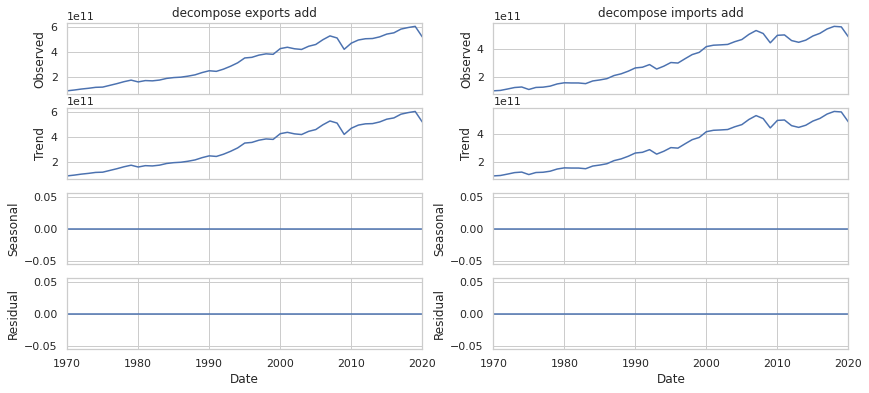

In [36]:
#Decomposing exports and Imports italian variables

def plotseasonal(res, axes):
    res.observed.plot(ax=axes[0], legend=False)
    axes[0].set_ylabel('Observed')
    res.trend.plot(ax=axes[1], legend=False)
    axes[1].set_ylabel('Trend')
    res.seasonal.plot(ax=axes[2], legend=False)
    axes[2].set_ylabel('Seasonal')
    res.resid.plot(ax=axes[3], legend=False)
    axes[3].set_ylabel('Residual')

decompose_exports= seasonal_decompose(exports, model='additive')
decompose_imports = seasonal_decompose(imports, model='additive')

fig, axes = plt.subplots(ncols=2, nrows=4, sharex=True, figsize=(14,6))
plotseasonal(decompose_exports, axes[:,0])
axes[0,0].set_title('decompose exports add')
plotseasonal(decompose_imports, axes[:,1])
axes[0,1].set_title('decompose imports add');

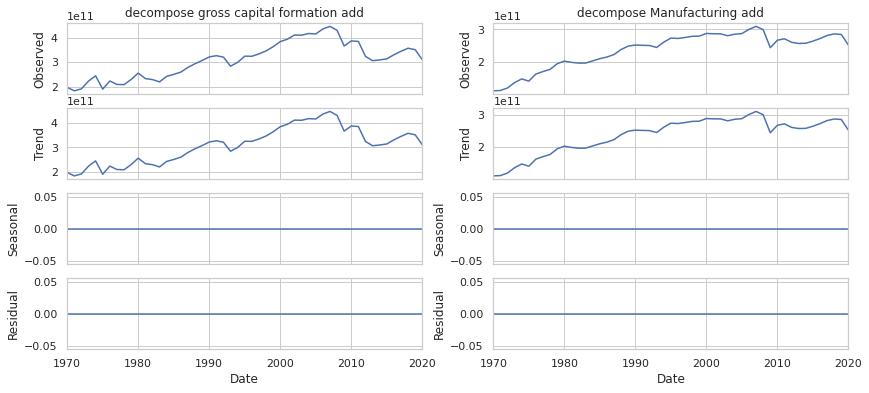

In [37]:
#Decomposing Gross capital formation and manufacturing (ISIC D) italian variables
decompose_gross_cap_form_add = seasonal_decompose(gross_cap_form, model='additive')
decompose_manufact_add = seasonal_decompose(manufact, model='additive')

fig, axes = plt.subplots(ncols=2, nrows=4, sharex=True, figsize=(14,6))
plotseasonal(decompose_gross_cap_form_add, axes[:,0])
axes[0,0].set_title('decompose gross capital formation add')
plotseasonal(decompose_manufact_add, axes[:,1])
axes[0,1].set_title('decompose Manufacturing add');

As before, the entire series is taken as the trend component and there seems to be no seasonality. We can also see that the residual plot shows zero. The problem with decomposition here is that the time interval considered is = year.
What we can do in this case is decompose the **trend and cyclical pattern** by applying a **moving average smoothing**.

In [38]:
exports = exports.to_frame()
imports = imports.to_frame()
gross_cap_form = gross_cap_form.to_frame()
manufact = manufact.to_frame()

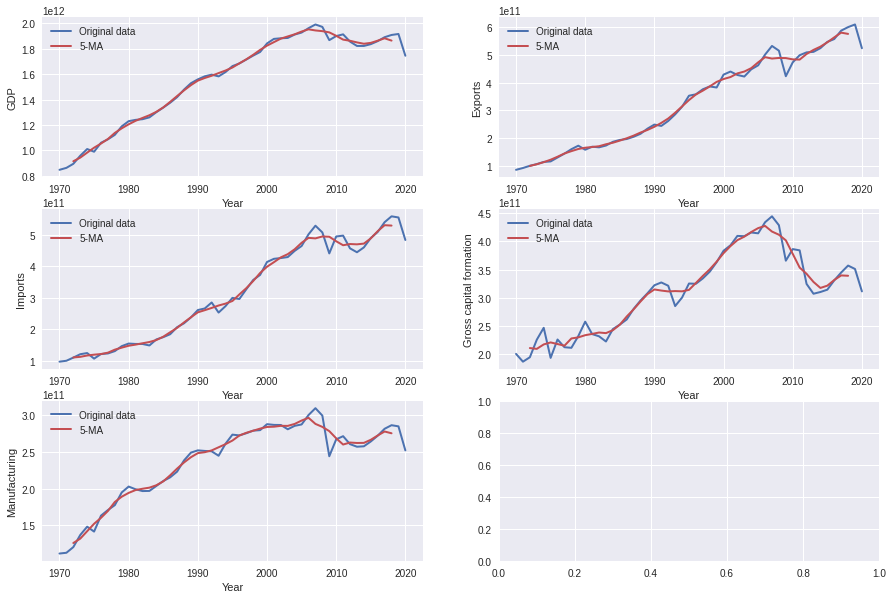

In [39]:
ita_gdp['5-MA'] = ita_gdp['Value'].rolling(5, center=True).mean()
exports['5-MA'] = exports['Exports of goods and services'].rolling(5, center=True).mean()
imports['5-MA'] = imports['Imports of goods and services'].rolling(5, center=True).mean()
gross_cap_form['5-MA'] = gross_cap_form['Gross capital formation'].rolling(5, center=True).mean()
manufact['5-MA'] = manufact['Manufacturing (ISIC D)'].rolling(5, center=True).mean() 
plt.style.use('seaborn')
fig, ax = plt.subplots(3,2,figsize=(15,10))
ax[0,0].plot(ita_gdp['Value'],'b-',label = 'Original data', linewidth=2)
ax[0,0].plot(ita_gdp['5-MA'],'r-',label = '5-MA', linewidth=2)
ax[0,0].legend()
ax[0,0].set_xlabel('Year')
ax[0,0].set_ylabel('GDP');

ax[0,1].plot(exports['Exports of goods and services'],'b-',label = 'Original data', linewidth=2)
ax[0,1].plot(exports['5-MA'],'r-',label = '5-MA', linewidth=2)
ax[0,1].legend()
ax[0,1].set_xlabel('Year')
ax[0,1].set_ylabel('Exports');

ax[1,0].plot(imports['Imports of goods and services'],'b-',label = 'Original data', linewidth=2)
ax[1,0].plot(imports['5-MA'],'r-',label = '5-MA', linewidth=2)
ax[1,0].legend()
ax[1,0].set_xlabel('Year')
ax[1,0].set_ylabel('Imports');

ax[1,1].plot(gross_cap_form['Gross capital formation'],'b-',label = 'Original data', linewidth=2)
ax[1,1].plot(gross_cap_form['5-MA'],'r-',label = '5-MA', linewidth=2)
ax[1,1].legend()
ax[1,1].set_xlabel('Year')
ax[1,1].set_ylabel('Gross capital formation');

ax[2,0].plot(manufact['Manufacturing (ISIC D)'],'b-',label = 'Original data', linewidth=2)
ax[2,0].plot(manufact['5-MA'],'r-',label = '5-MA', linewidth=2)
ax[2,0].legend()
ax[2,0].set_xlabel('Year')
ax[2,0].set_ylabel('Manufacturing');

#4.Models for forecasting

##Linear Regression
We are gonna create time dummy representing the years. We rely on a time dummy which counts the steps in the series from beginning to end. The aim is to  predict the dependent variable (italian GDP) using time-features (time-step features).

In [40]:
ita_gdp['Year'] = range(ita_gdp.shape[0])
ita_gdp.head(10)

,Value,5-MA,Year
Date,,,
1970-01-01,8.466100e+11,NaN,0
1971-01-01,8.620023e+11,NaN,1
1972-01-01,8.938143e+11,9.140207e+11,2
1973-01-01,9.575063e+11,9.425099e+11,3
1974-01-01,1.010171e+12,9.820156e+11,4
1975-01-01,9.890563e+11,1.020585e+12,5
1976-01-01,1.059530e+12,1.053457e+12,6
1977-01-01,1.086660e+12,1.089168e+12,7
1978-01-01,1.121869e+12,1.137256e+12,8


Intercept 1005381793689.1779
Slope 22158647786.72263
RMSE value is:  125759996607.22401


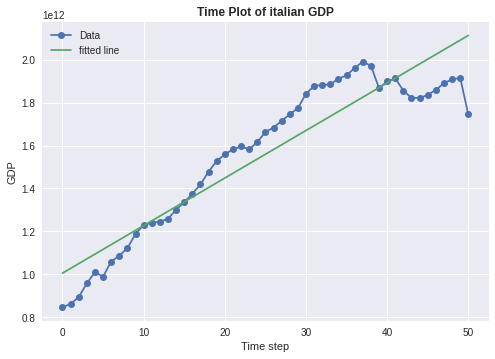

In [41]:
# Regression with the time dummy just created
x = ita_gdp['Year'].values
y = ita_gdp['Value'].values

x = x.reshape(len(x),1)
y = y.reshape(len(y),1)

model = LinearRegression().fit(x, y)
fitted_line = model.predict(x)
print('Intercept', float(model.intercept_))
print('Slope', float(model.coef_)) 
print('RMSE value is: ', np.sqrt(mean_squared_error(y, fitted_line)))

plt.plot(x, y, marker='o',label='Data')
plt.grid()
plt.title('Time Plot of italian GDP',weight='bold');
plt.plot(x,fitted_line,label='fitted line');
plt.xlabel('Time step')
plt.ylabel('GDP')
plt.grid()
plt.legend();

In [42]:
#Parameter for assessing model performance: AIC
N = len(y)
n_params = x.shape[1]
error = sum((y-fitted_line)**2)

# Calculate AIC for regression
s2 = error/N
LL  = -N/2*(1+np.log(2*np.pi)+np.log(s2))
AIC = -2*LL + 2*(n_params+1)
print('Manual AIC Linear Regression:', float(AIC))

Manual AIC Linear Regression: 2755.611126529088


##Forecasting with ETS models
We will now use first a **Simple Exponential Smoothing** to forecast the data and we'll compare it with the **Holt’s linear trend method** (Double Exponential Smoothing) with **damped trend** (using additive method). We will measure the AIC and RMSE to compare the models and see which performs better.

In [43]:
ita_gdp.index
ita_gdp.Value.tail()

Date
2016-01-01    1.859646e+12
2017-01-01    1.890662e+12
2018-01-01    1.908166e+12
2019-01-01    1.915995e+12
2020-01-01    1.744732e+12
Freq: AS-JAN, Name: Value, dtype: float64

**Simple Exponential Smoothing**: 
This method is suitable for forecasting data with no clear trend or seasonal pattern. Forecasts are calculated using weighted averages, where the weights decrease exponentially as observations are distant in the past. SES has one forecast equation and a single smoothing equation for the level.

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning:

The 'freq' argument in Timestamp is deprecated and will be removed in a future version.



,Param Name,Values
0,smoothing_level,9.999000e-01
1,initial_level,7.966852e+11


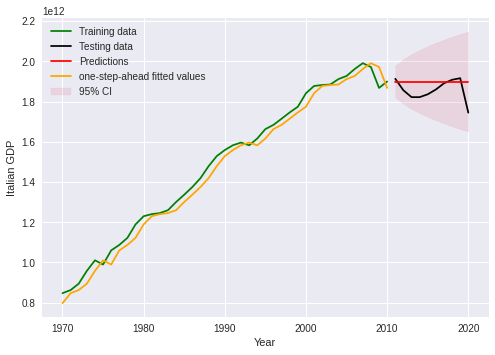

In [44]:
# Simple Exponential Smoothing 
# Train and Test (last ten years)
data_train_italy = ita_gdp.Value[:-10]
data_test_italy = ita_gdp.Value[-10:]

# Train the model and predictions
model = ETSModel(data_train_italy).fit()
predictions = model.forecast(10)

# Forecasting in the future and confidence interval
pred = model.get_prediction(start='2011-01-01', end='2020-01-01')
df = pred.summary_frame()

# Model parameters
tab = {'Param Name': model.param_names, 'Values': model.params}
tab = pd.DataFrame(tab)
display(tab)

# Plot
plt.plot(data_train_italy, color='green',label='Training data')
plt.plot(data_test_italy, color='black', label='Testing data')
plt.plot(predictions, color='red', label='Predictions')
plt.plot(model.fittedvalues,color='orange', label='one-step-ahead fitted values') 
plt.fill_between(df.index, df['pi_lower'], df['pi_upper'], alpha=.1, color='crimson', label='95% CI')
plt.xlabel('Year')
plt.ylabel('Italian GDP')
plt.legend();

**Holt’s linear trend method (Double Exponential Smoothing)**: extended SES method to allow the forecasting of data with a trend. This method involves a forecast equation and two smoothing equations (one for the level and one for the trend). To avoid over-forecast we use a parameter that “dampens” the trend to a flat line in the future.

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning:

The 'freq' argument in Timestamp is deprecated and will be removed in a future version.



,Param Name,Values
0,smoothing_level,9.999000e-01
1,smoothing_trend,9.999000e-05
2,damping_trend,9.800000e-01
3,initial_level,7.966852e+11
4,initial_trend,3.725617e+10


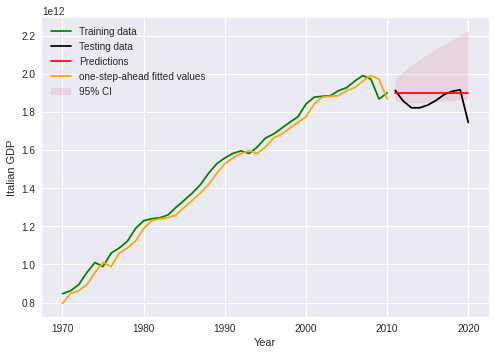

In [45]:
#Forecasting with the Holt Method with damped trend
# Train and Test (last ten years)
data_train_italy = ita_gdp.Value[:-10]
data_test_italy = ita_gdp.Value[-10:]

# Train the model and predictions
Model = ETSModel(data_train_italy, trend='add', damped_trend=True).fit()
predictions = model.forecast(10)

# Forecasting in the future and confidence interval
pred = Model.get_prediction(start='2011-01-01', end='2020-01-01')
df = pred.summary_frame()

# Model parameters
tab = {'Param Name': Model.param_names, 'Values': Model.params}
tab = pd.DataFrame(tab)
display(tab)

# Plot
plt.plot(data_train_italy, color='green',label='Training data')
plt.plot(data_test_italy, color='black', label='Testing data')
plt.plot(predictions, color='red', label='Predictions')
plt.plot(model.fittedvalues,color='orange', label='one-step-ahead fitted values') 
plt.fill_between(df.index, df['pi_lower'], df['pi_upper'], alpha=.1, color='crimson', label='95% CI')
plt.xlabel('Year')
plt.ylabel('Italian GDP')
plt.legend();

In [46]:
# Comparing AIC
print('AIC Simple exponential smoothing:', model.aic)
print('AIC H+damped trend:', Model.aic)

# Comparing RMSE
print('RMSE Simple exponential smoothing:', np.sqrt(model.mse))
print('RMSE H+damped trend:', np.sqrt(Model.mse))

AIC Simple exponential smoothing: 2124.5732912398726
AIC H+damped trend: 2102.461536268486
RMSE Simple exponential smoothing: 40207569708.92866
RMSE H+damped trend: 28537785008.885223


Evaluating both models with AIC and RMSE we can notice that the second one (the Holt Method with damped trend) is the best model to fit the data

##Forecasting with ARIMA model

In [47]:
ita_gdp.Value.head()

Date
1970-01-01    8.466100e+11
1971-01-01    8.620023e+11
1972-01-01    8.938143e+11
1973-01-01    9.575063e+11
1974-01-01    1.010171e+12
Freq: AS-JAN, Name: Value, dtype: float64

In [48]:
# Train/test split (last ten years as testing)
data_train = ita_gdp.Value[:-10]
data_test = ita_gdp.Value[-10:]

In [49]:
# Test for check stationarity
result_ADF = adfuller(data_train)
# Print ADF p-value (p<0.05 to have stationarity)
print('ADF p-value:', result_ADF[1])

kpss_test = kpss(data_train, regression='ct', nlags='auto', store=True)
# Print KPSS p-value (p>0.05 to have stationarity)
print('KPSS p-value: ', kpss_test[1])

#Time series is not stationary -> differencing to be applied 

ADF p-value: 0.1774829524844554
KPSS p-value:  0.011329877116409084


ADF Statistic: -4.059965143089812
ADF p-value: 0.001127098503611619
KPSS Statistic: 0.09420573587677772
KPSS p-value:  0.1


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




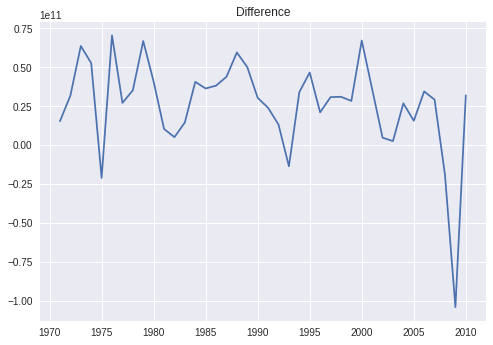

In [50]:
train = data_train.diff()
train.dropna(inplace=True)

plt.plot(train)
plt.title('Difference')

result_ADF = adfuller(train)
print('ADF Statistic:', result_ADF[0])
print('ADF p-value:', result_ADF[1])

kpss_test = kpss(train, regression='ct', nlags='auto', store=True)
print('KPSS Statistic:', kpss_test[0])
print('KPSS p-value: ', kpss_test[1])

#Serie is stationary now

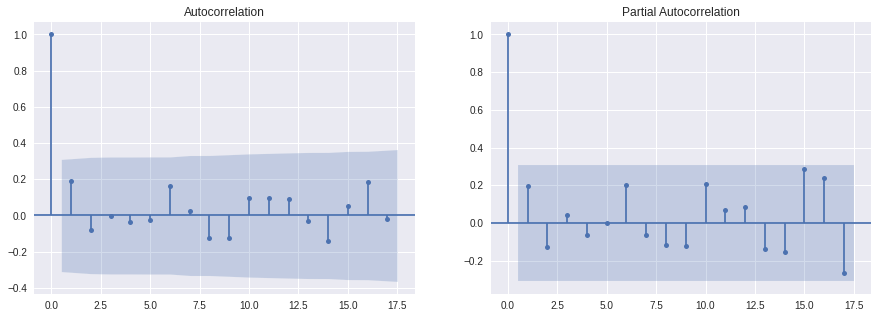

In [51]:
# ACF and PACF plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
plot_acf(train, ax=ax1);
plot_pacf(train, ax=ax2);

In [52]:
#to choose the model parameters (in particular p and q) - Auto-ARIMA
!pip install pmdarima
from pmdarima.arima import auto_arima

arima_model =  auto_arima(data_train, start_p=0, d=0, start_q=0, 
                          max_p=6, max_q=6, m=1, seasonal=False, 
                          error_action='warn',trace = True,
                          supress_warnings=True,stepwise = False,
                          random_state=20,information_criterion='aicc')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 36.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 91.1 MB/s eta 0:00:00
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


 ARIMA(0,0,0)(0,0,0)[0]             : AICC=2418.970, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AICC=2395.501, Time=0.09 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AICC=2393.010, Time=0.07 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AICC=2395.678, Time=0.14 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AICC=2399.823, Time=0.15 sec
 ARIMA(0,0,5)(0,0,0)[0]             : AICC=2401.716, Time=0.15 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AICC=inf, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AICC=2122.672, Time=0.19 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AICC=2125.552, Time=0.24 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AICC=inf, Time=0.43 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AICC=inf, Time=0.30 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AICC=inf, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AICC=2111.355, Time=0.22 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AICC=inf, Time=0.21 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AICC=2128.849, Time=0.25 sec
 ARIMA(3,0,0)(0,0,0)

In [53]:
from statsmodels.tsa.arima.model import ARIMA

# Model parameter estimations
mod_ARIMA = ARIMA(data_train, order=(2,1,1)).fit() #order of integration 1 in order to make the series stationary.

#Visualize the statistics and main results 
print(mod_ARIMA.summary()) 
print('Estimated Coefficients:', mod_ARIMA.params)

                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                   41
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -1020.426
Date:                Tue, 28 Feb 2023   AIC                           2048.851
Time:                        09:44:32   BIC                           2055.607
Sample:                    01-01-1970   HQIC                          2051.294
                         - 01-01-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9422      0.180      5.225      0.000       0.589       1.296
ar.L2          0.0283      0.161      0.176      0.860      -0.287       0.343
ma.L1         -0.9364      0.043    -21.703      0.0

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/gofplots.py:993: UserWarning:

marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.



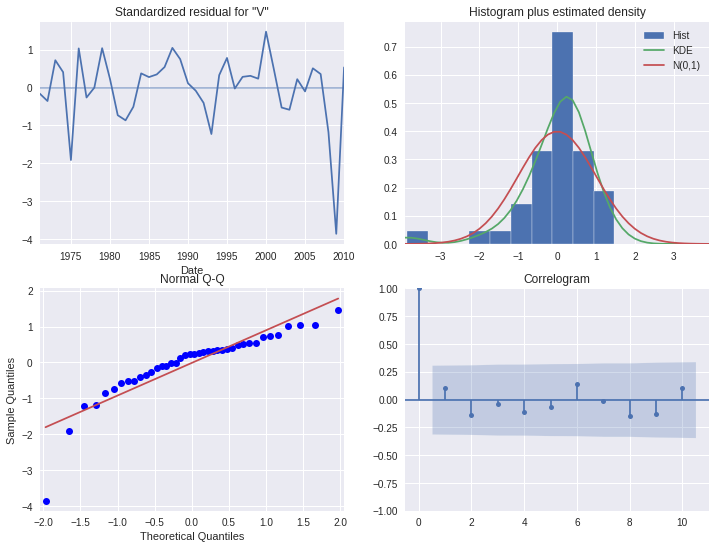

In [54]:
mod_ARIMA.plot_diagnostics(figsize=(12,9));

Here the Jarque-Bera Test (it checks if the sample data has the skewness and kurtosis matching a normal distribution) may not work well since we don't have a large sample (usually works with > 2000 observations). Here we have just 51 observations.

**Residuals’ diagnostics of the ARIMA(2,1,1) model.**
In the top-left plot, the residuals have no trend with a variance that seems fairly constant over time, which resembles the behavior of white noise. The top-right plot shows the distribution of the residuals, which approaches a normal distribution, despite the unusual peak. The Q-Q plot at the bottom left, which displays a fairly straight line that lies on y = x (even if this plot works best with a large number of observations). Finally, the correlogram in the bottom-right plot shows no significant autocorrelation coefficients after lag 0, approximately looking like white noise. We can conclude that the model is a good fit for our time series data.

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning:

The 'freq' argument in Timestamp is deprecated and will be removed in a future version.



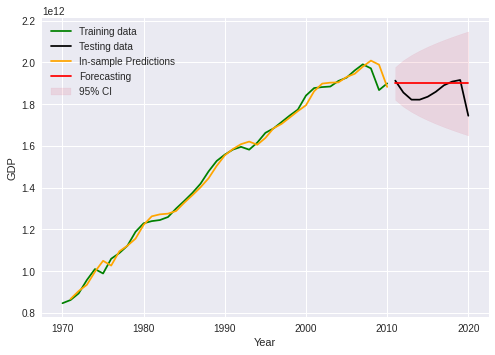

In [55]:
# Forecasting for the test set data
predictions = model.get_prediction(start=data_test.index[0], end=data_test.index[-1]) 
df = predictions.summary_frame()

# Plot with confidence interval
plt.plot(data_train, color='green',label='Training data')
plt.plot(data_test, color='black', label='Testing data')
plt.plot(mod_ARIMA.fittedvalues[1:], color='orange',label='In-sample Predictions')
plt.plot(df['mean'], color='red', label='Forecasting')
plt.fill_between(df.index, df['pi_lower'], df['pi_upper'], alpha=.1, color='crimson', label='95% CI')
plt.xlabel('Year')
plt.ylabel('GDP')
plt.legend(loc='best');

In [56]:
print('AIC ARIMA: ', mod_ARIMA.aic)
print('RMSE ARIMA: ', np.sqrt(mod_ARIMA.mse))

AIC ARIMA:  2048.851033214659
RMSE ARIMA:  135239503096.30325


Seems the best models (in terms of AIC) are the ARIMA one and the Holt method +damped trend:

*   AIC Linear Regression: 2755.611126529088
*   AIC Simple exponential smoothing: 2124.5732912398726
*   **AIC H+damped trend: 2102.461536268486**
*   **AIC ARIMA: 2048.851033214659**

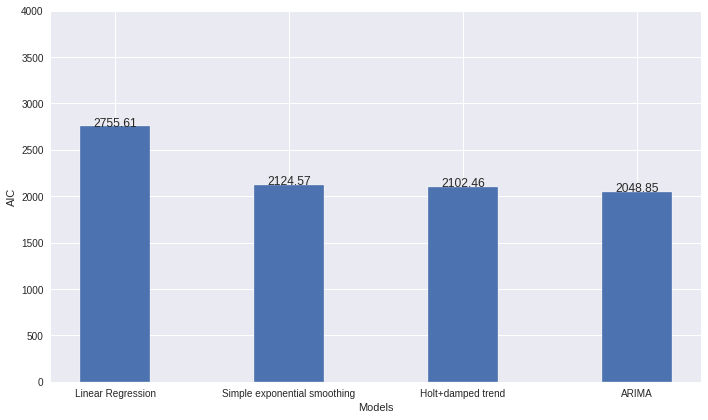

In [57]:
fig, ax = plt.subplots(figsize=(10,6))
x = ['Linear Regression', 'Simple exponential smoothing', 'Holt+damped trend', 'ARIMA']
y = [float(AIC), model.aic, Model.aic, mod_ARIMA.aic]
 
ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('AIC')
ax.set_ylim(0, 4000)
 
for index, value in enumerate(y):
    plt.text(x=index, y=value + 1, s=str(round(value,2)), ha='center')
 
plt.tight_layout()

## Forecasting for other 4 countries

,AIC,RMSE
China,2155.351465,5.439260e+10


,AIC,RMSE
India,2064.880122,1.804591e+10


,AIC,RMSE
Italy,2102.461536,2.853779e+10


,AIC,RMSE
Singapore,1968.209024,5.551140e+09


,AIC,RMSE
United Kingdom,2133.120769,4.147630e+10


,AIC,RMSE
United States,2266.832869,2.118244e+11


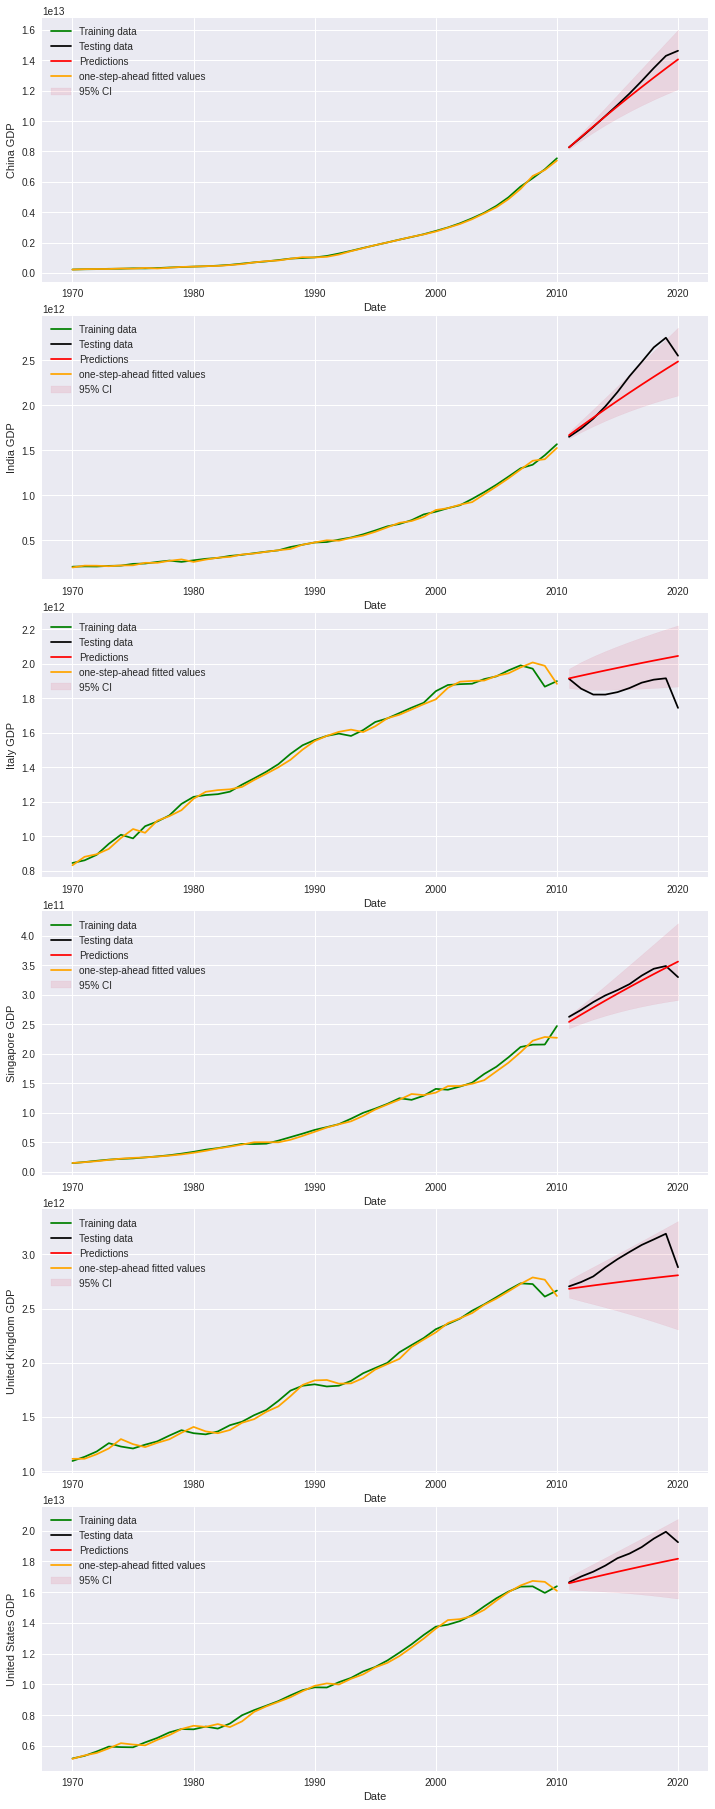

In [58]:
#Forecasting with the Holt Method with damped trend
# Train and Test (last ten years)
fig, ax = plt.subplots(6,1, figsize=(10,25))
fig.tight_layout()
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
n=0
for i in pivot1.columns:
  piv = pivot1[i].asfreq('AS')
  data_train = piv[:-10]
  data_test = piv[-10:]
  Mod = ETSModel(data_train, trend='add', damped_trend=True).fit()
  predictions = Mod.forecast(10)
  predic = Mod.get_prediction(start='2011-01-01', end='2020-01-01')
  df = predic.summary_frame()
  ax[n].plot(data_train, color='green',label='Training data')
  ax[n].plot(data_test, color='black', label='Testing data')
  ax[n].plot(predictions, color='red', label='Predictions')
  ax[n].plot(Mod.fittedvalues,color='orange', label='one-step-ahead fitted values') 
  ax[n].fill_between(df.index, df['pi_lower'], df['pi_upper'], alpha=.1, color='crimson', label='95% CI')
  ax[n].set_xlabel('Date')
  ax[n].set_ylabel(str(pivot1.columns[n])+' GDP')
  ax[n].legend()
  tab = {'AIC': [Mod.aic], 'RMSE': [np.sqrt(Mod.mse)]}
  tab = pd.DataFrame(tab, index=[str(pivot1.columns[n])])
  display(tab)
  n+=1